In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score


In [2]:

# Load the data (Paw, Flow, Volume)
data = np.loadtxt("Supplementary/data/case2VCAC2.txt")  # update path if needed
Paw, Flow, Volume = data[:, 0], data[:, 1], data[:, 2]

# Time vector assuming 100 Hz sampling
fs = 100
num_seconds=8
t = np.linspace(0, len(Paw) / fs, len(Paw))

# Select 3 breaths (~12 sec) manually (adjust start/end if needed)
start_idx = 5   # Start at sample 5 to skip initial transient
end_idx = min(start_idx + fs*num_seconds, len(t))  # 4 seconds = 400 samples
print(start_idx,end_idx)

# Extract segments
t_seg = t[start_idx:end_idx]
V_seg = Volume[start_idx:end_idx]
Flow_seg = Flow[start_idx:end_idx]
Paw_seg = Paw[start_idx:end_idx]


5 805


In [3]:
print(t.shape)

(15000,)


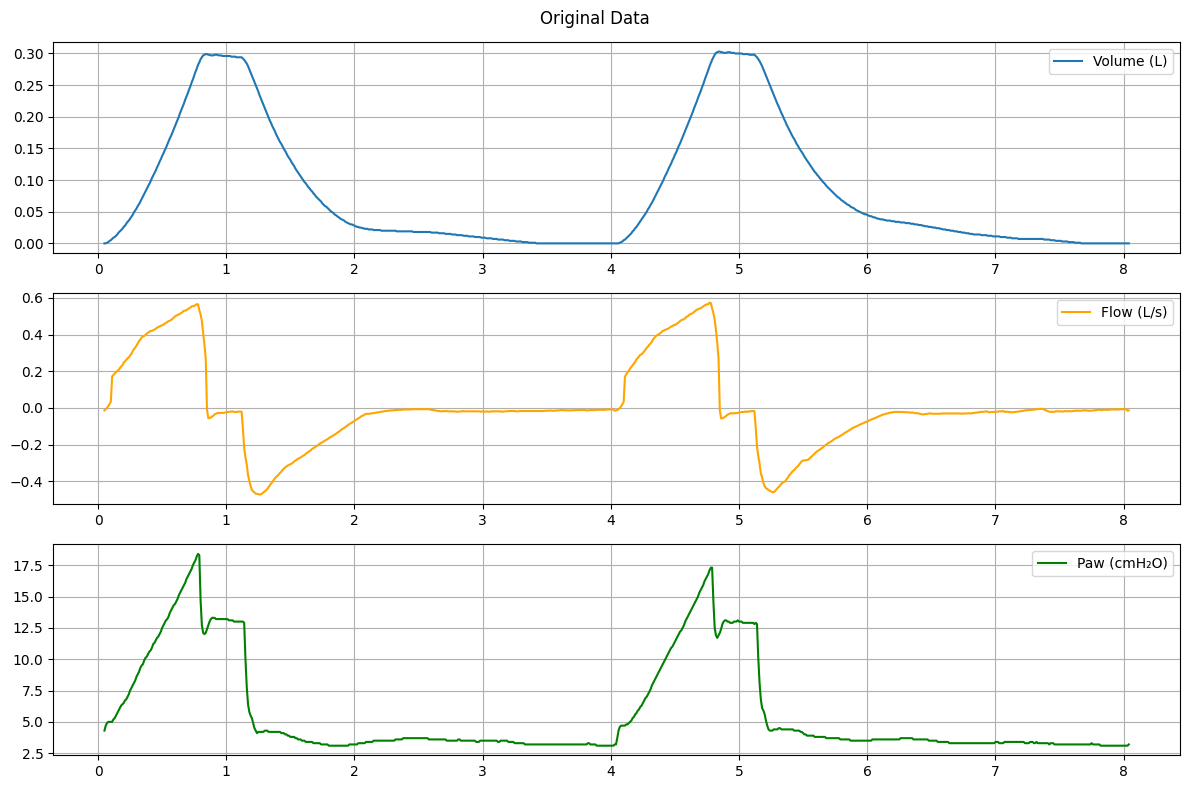

In [4]:
# Plot

plt.figure(figsize=(12, 8))
plt.suptitle('Original Data')
#plt.title('Original data')
plt.subplot(3, 1, 1)
plt.plot(t_seg, V_seg, label="Volume (L)")
plt.grid(), plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_seg, Flow_seg, label="Flow (L/s)", color='orange')
plt.grid(), plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_seg, Paw_seg, label="Paw (cmH₂O)", color='green')
plt.grid(), plt.legend()



plt.tight_layout()

plt.show()

### Fit equation 1

$$
P_{aw}(t) = E \cdot V(t) + R \cdot V'(t) + P_0
$$

Fitted Parameters:
E = 29.95, R = 10.27, P0 = 3.17
Mean Squared Error (MSE) = 0.4978
R-squared (R²) = 0.9686


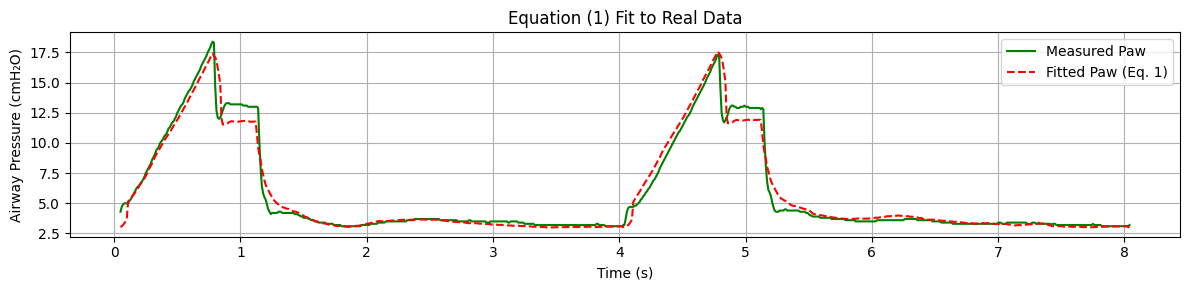

In [5]:
# estimate E, R and P0


# Define Eq. 1
def eq1(X, E, R, P0):
    V, Flow = X
    return E * V + R * Flow + P0

# Fit the model to the selected segment
popt, _ = curve_fit(eq1, (V_seg, Flow_seg), Paw_seg)
E_true=popt[0]
R_true = popt[1]
P0_true = popt[2]     

# Generate fitted Paw
Paw_fit = eq1((V_seg, Flow_seg), *popt)



mse = mean_squared_error(Paw_seg, Paw_fit)
r2 = r2_score(Paw_seg, Paw_fit)



# Print results
print(f"Fitted Parameters:\nE = {E_true:.2f}, R = {R_true:.2f}, P0 = {P0_true:.2f}")

print(f"Mean Squared Error (MSE) = {mse:.4f}")
print(f"R-squared (R²) = {r2:.4f}")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(t_seg, Paw_seg, label="Measured Paw", color="green")
plt.plot(t_seg, Paw_fit, label="Fitted Paw (Eq. 1)", linestyle="--", color="red")
plt.title("Equation (1) Fit to Real Data")
plt.xlabel("Time (s)")
plt.ylabel("Airway Pressure (cmH₂O)")
plt.grid(), plt.legend()
plt.tight_layout()
plt.show()


In [6]:
Paw_seg.shape

(800,)

In [7]:
## Generate synthetic data

In [8]:
# Volume signal: sinusoidal breathing (0.5L amplitude, 15 breaths/min)
A = 0.5
f_breath = 0.25  # Hz (15 bpm)
V_synth = A * np.sin(2 * np.pi * f_breath * t_seg)

# Flow = dV/dt
Flow_synth = np.gradient(V_synth, t_seg)

# Equation (1) parameters
# E, R, P0 should come from estimated


# Simulate Paw using Equation (1)
#Paw = E * V + R * Flow + P0
X=(V_synth,Flow_synth)
Paw_synth=eq1(X, E_true, R_true, P0_true)

print(Paw_synth.shape)

(800,)


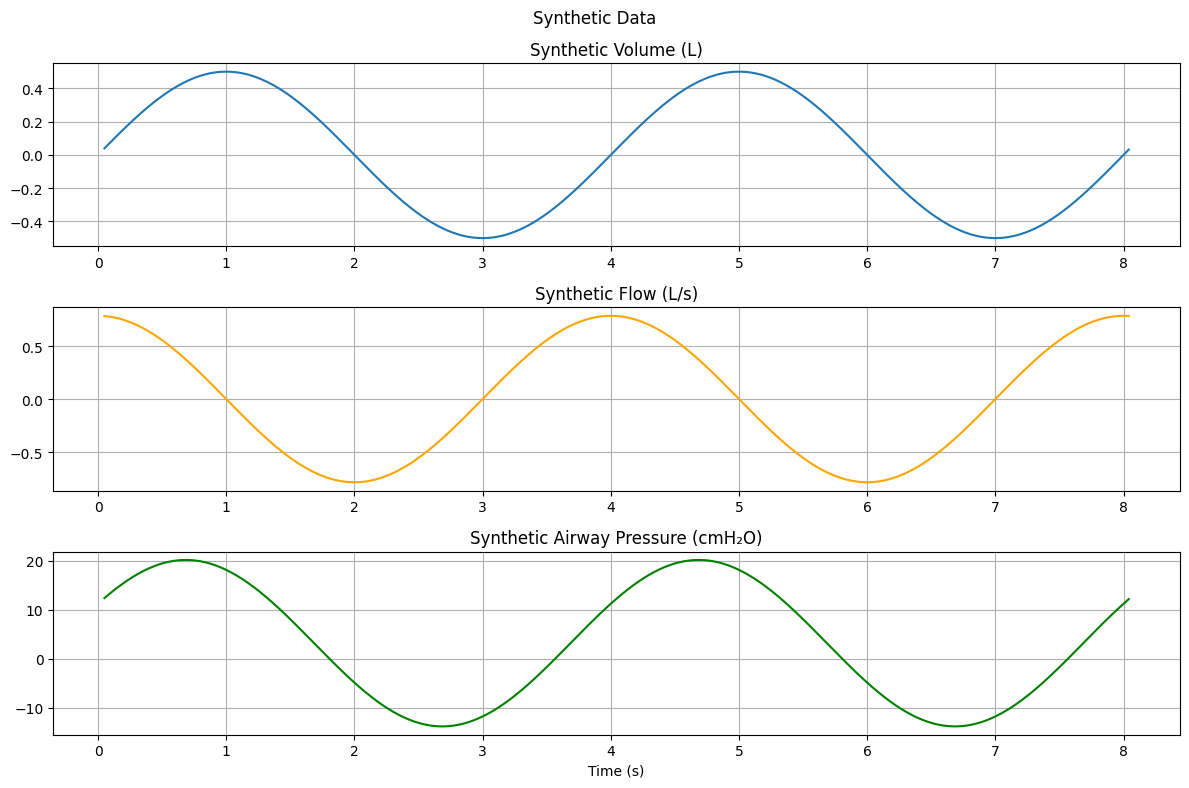

In [9]:
# Plot the synthetic signals
plt.figure(figsize=(12, 8))
plt.suptitle('Synthetic Data')

plt.subplot(3, 1, 1)
plt.plot(t_seg, V_synth)
plt.title("Synthetic Volume (L)")
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t_seg, Flow_synth, color='orange')
plt.title("Synthetic Flow (L/s)")
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t_seg, Paw_synth, color='green')
plt.title("Synthetic Airway Pressure (cmH₂O)")
plt.xlabel("Time (s)")
plt.grid()

plt.tight_layout()
plt.show()

In [10]:
## Estimate the parameters from synthetic data using PINN

Epoch 0 | Loss: 141.2673 | E: 1.01, R: 1.01, P0: 0.01
Epoch 200 | Loss: 109.7925 | E: 2.98, R: 2.92, P0: 1.71
Epoch 400 | Loss: 88.7390 | E: 4.89, R: 4.60, P0: 2.68
Epoch 600 | Loss: 72.9864 | E: 6.72, R: 6.04, P0: 3.06
Epoch 800 | Loss: 60.3672 | E: 8.50, R: 7.24, P0: 3.15
Epoch 1000 | Loss: 50.0425 | E: 10.21, R: 8.20, P0: 3.17
Epoch 1200 | Loss: 41.4775 | E: 11.86, R: 8.93, P0: 3.17
Epoch 1400 | Loss: 34.2708 | E: 13.44, R: 9.46, P0: 3.17
Epoch 1600 | Loss: 28.1386 | E: 14.97, R: 9.81, P0: 3.17
Epoch 1800 | Loss: 22.8924 | E: 16.42, R: 10.03, P0: 3.17
Epoch 2000 | Loss: 18.4087 | E: 17.82, R: 10.15, P0: 3.17
Epoch 2200 | Loss: 14.6008 | E: 19.14, R: 10.22, P0: 3.17
Epoch 2400 | Loss: 11.3992 | E: 20.40, R: 10.25, P0: 3.17

Recovered Parameters:
E:  21.00 (true 29.945567866670835)
R:  10.25 (true 10.266538567980804)
P0: 3.17 (true 3.171018128178275)


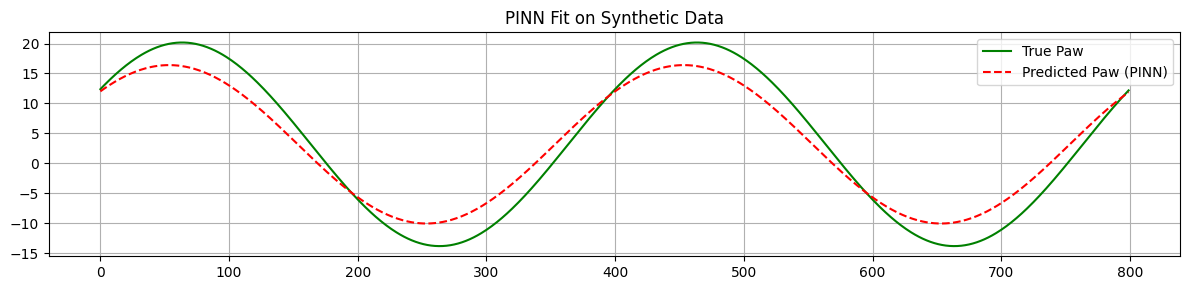

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt



# ==== Prepare PyTorch tensors ====
t_seg_torch = torch.tensor(t_seg, dtype=torch.float32).view(-1, 1)
V_synth_torch = torch.tensor(V_synth, dtype=torch.float32).view(-1, 1)
Flow_synth_torch = torch.tensor(Flow_synth, dtype=torch.float32).view(-1, 1)
Paw_synth_torch = torch.tensor(Paw_synth, dtype=torch.float32).view(-1, 1)

# ==== Define trainable parameters ====
E = torch.tensor([1.0], dtype=torch.float32, requires_grad=True)
R = torch.tensor([1.0], dtype=torch.float32, requires_grad=True)
P0 = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)

# ==== Define optimizer ====
optimizer = torch.optim.Adam([E, R, P0], lr=1e-2)
num_epochs=2500
# ==== Training loop ====
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Predicted Paw
    Paw_pred = E * V_synth_torch + R * Flow_synth_torch + P0

    # Loss = MSE
    loss = torch.mean((Paw_pred - Paw_synth_torch)**2)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | E: {E.item():.2f}, R: {R.item():.2f}, P0: {P0.item():.2f}")

# ==== Final Results ====
print("\nRecovered Parameters:")
print(f"E:  {E.item():.2f} (true {E_true})")
print(f"R:  {R.item():.2f} (true {R_true})")
print(f"P0: {P0.item():.2f} (true {P0_true})")

# ==== Plotting ====
plt.figure(figsize=(12, 3))
plt.plot(Paw_synth, label="True Paw", color='green')

X=(V_synth_torch,Flow_synth_torch)
Paw_synth_torch_hat=eq1(X, E, R, P0)


plt.plot(Paw_synth_torch_hat.detach().numpy(), '--', label="Predicted Paw (PINN)", color='red')
plt.title("PINN Fit on Synthetic Data")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()